In [ ]:
! pip install adversarial-robustness-toolbox
! pip install shap
! pip install lime
import tensorflow as tf
import numpy as np
from art.attacks.evasion import FastGradientMethod
from art.utils import to_categorical
from art.estimators.classification import KerasClassifier
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.utils import np_utils
import glob
import matplotlib.image as mpimg
import seaborn as sns
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import ProjectedGradientDescent
import shap
from lime import lime_image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 34.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=97b60dd5d4079e31bc569346649dbf625d7ac2df036681e1b0eb350e356b53db
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/ML_Project_006_012_017/Dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()#Close the zip file

In [ ]:
#defining categories for each kind of waste
categories = ['ewaste',
 'metal_cans',
 'plastic_bottles',
'plastic_bags',
'food_waste',
'paper_waste',
'wood_waste',
'leaf_waste'
 ]

In [ ]:
data = []
dir = "/tmp/Dataset/train/"

In [ ]:
#dividing the images into features and labels category where labels will be the target column for training the model
for category in categories:
  path = os.path.join(dir,category)
  label = categories.index(category)

  for img in os.listdir(path):
    imgpath = os.path.join(path,img)
    waste_img = cv2.imread(imgpath,0)
    waste_img = cv2.resize(waste_img,(32,32))
    image = np.array(waste_img).flatten()

    data.append([image,label])

In [ ]:
import pandas as pd
sdir=r'/tmp/Dataset/'
categories=[ 'train', 'val']
for category in categories:
    category_path=os.path.join(sdir, category)
    filepaths=[]
    labels=[]
    classlist=os.listdir(category_path)
    for klass in classlist:
        classpath=os.path.join(category_path,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if category=='train':
        train_df=pd.concat([Fseries, Lseries], axis=1)
    else:
        valid_df=pd.concat([Fseries, Lseries], axis=1)

In [ ]:
print (train_df.head())
print('train_df length: ', len(train_df), '  valid_df length: ', len(valid_df))
print (train_df['labels'].value_counts())

                                      filepaths        labels
0  /tmp/Dataset/train/plastic_bags/00000210.jpg  plastic_bags
1  /tmp/Dataset/train/plastic_bags/00000100.jpg  plastic_bags
2  /tmp/Dataset/train/plastic_bags/00000171.jpg  plastic_bags
3  /tmp/Dataset/train/plastic_bags/00000316.jpg  plastic_bags
4  /tmp/Dataset/train/plastic_bags/00000083.jpg  plastic_bags
train_df length:  14165   valid_df length:  1201
food_waste         10066
leaf_waste          1179
paper_waste          860
metal_cans           670
wood_waste           593
plastic_bottles      417
plastic_bags         200
ewaste               180
Name: labels, dtype: int64


In [ ]:
print (valid_df['labels'].value_counts())

leaf_waste         394
food_waste         229
paper_waste        212
plastic_bottles    130
metal_cans          69
wood_waste          59
ewaste              55
plastic_bags        53
Name: labels, dtype: int64


In [ ]:
sample_list=[]
max_size= 1179
groups=train_df.groupby('labels')
for label in train_df['labels'].unique():
    group=groups.get_group(label)
    sample_count=len(group)
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
train_df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(train_df))
print (train_df['labels'].value_counts())

5278
food_waste         1179
leaf_waste         1179
paper_waste         860
metal_cans          670
wood_waste          593
plastic_bottles     417
plastic_bags        200
ewaste              180
Name: labels, dtype: int64


In [ ]:
import shutil
working_dir=r'./'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in train_df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['plastic_bags', 'ewaste', 'paper_waste', 'plastic_bottles', 'metal_cans', 'food_waste', 'wood_waste', 'leaf_waste']


In [ ]:
!pip install Keras-Preprocessing
from keras_preprocessing.image import ImageDataGenerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.1 MB/s eta 0:00:00


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
target=1179 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=train_df.groupby('labels') # group by class
for label in train_df['labels'].unique():  # for every class
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label
    sample_count=len(group)   # determine how many samples there are in this class
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(400,400), class_mode=None, batch_size=1,
                                         shuffle=False, save_to_dir=target_dir, save_prefix='aug-',save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)
            aug_img_count += len(images)

Found 200 validated image filenames.


Palette images with Transparency expressed in bytes should be converted to RGBA images


Found 180 validated image filenames.
Found 860 validated image filenames.
Found 417 validated image filenames.
Found 670 validated image filenames.
Found 593 validated image filenames.


In [ ]:
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filepaths')
Lseries=pd.Series(aug_labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)
print ('length of aug_df" ', len(aug_df))
train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
train_df=train_df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
print ('length of train_df is: ', len(train_df))
print (train_df['labels'].value_counts())

length of aug_df"  4154
length of train_df is:  9432
wood_waste         1179
plastic_bottles    1179
ewaste             1179
paper_waste        1179
metal_cans         1179
plastic_bags       1179
leaf_waste         1179
food_waste         1179
Name: labels, dtype: int64


In [ ]:
# sample_list=[]
# max_size= 150
# groups=valid_df.groupby('labels')
# for label in valid_df['labels'].unique():
#     group=groups.get_group(label)
#     sample_count=len(group)
#     if sample_count> max_size:
#         samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
#     else:
#         samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
#     sample_list.append(samples)
# valid_df=pd.concat(sample_list, axis=0).reset_index(drop=True)
# print (len(valid_df))
# print (valid_df['labels'].value_counts())

In [ ]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True
# target=150 # set the target count for each class in df
# gen=ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, width_shift_range=.2,
#                               height_shift_range=.2, zoom_range=.2)
# groups=valid_df.groupby('labels') # group by class
# for label in valid_df['labels'].unique():  # for every class
#     group=groups.get_group(label)  # a dataframe holding only rows with the specified label
#     sample_count=len(group)   # determine how many samples there are in this class
#     if sample_count< target: # if the class has less than target number of images
#         aug_img_count=0
#         delta=target-sample_count  # number of augmented images to create
#         target_dir=os.path.join(aug_dir, label)  # define where to write the images
#         aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(400,400), class_mode=None, batch_size=1,
#                                          shuffle=False, save_to_dir=target_dir, save_prefix='aug-',save_format='jpg')
#         while aug_img_count<delta:
#             images=next(aug_gen)
#             aug_img_count += len(images)

In [ ]:
# aug_fpaths=[]
# aug_labels=[]
# classlist=os.listdir(aug_dir)
# for klass in classlist:
#     classpath=os.path.join(aug_dir, klass)
#     flist=os.listdir(classpath)
#     for f in flist:
#         fpath=os.path.join(classpath,f)
#         aug_fpaths.append(fpath)
#         aug_labels.append(klass)
# Fseries=pd.Series(aug_fpaths, name='filepaths')
# Lseries=pd.Series(aug_labels, name='labels')
# aug_df=pd.concat([Fseries, Lseries], axis=1)
# print ('length of aug_df" ', len(aug_df))
# valid_df=pd.concat([valid_df,aug_df], axis=0).reset_index(drop=True)
# valid_df=valid_df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
# print ('length of valid_df is: ', len(valid_df))
# print (valid_df['labels'].value_counts())

In [ ]:
height=400
width=400
channels=3
batch_size=20
img_shape=(height, width, channels)
img_size=(height, width)


def scalar(img):
    #img=img/127.5-1
    return img
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
sdir=r'/tmp/Dataset/'
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

Found 9432 validated image filenames belonging to 8 classes.
Found 1201 validated image filenames belonging to 8 classes.


In [ ]:
train = '/tmp/Dataset/train/'
val = '/tmp/Dataset/val/'

# CNN

In [ ]:
# Disable eager execution
tf.compat.v1.disable_eager_execution()

In [ ]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_gen=datagen.flow_from_dataframe(

train_df,
x_col="filepaths",
y_col="labels",
batch_size=64,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

valid_gen=datagen.flow_from_dataframe(

valid_df,
x_col="filepaths",
y_col="labels",
batch_size=64,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 9432 validated image filenames belonging to 8 classes.
Found 1201 validated image filenames belonging to 8 classes.


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1_l2

def create_model(lr=0.001, epochs=10, dropout=0.2, optimizer='adam', loss='categorical_crossentropy',
                 activation='relu', clipnorm=1.0, momentum=0.9, decay=0.0, l1=0.0, l2=0.0,
                 no_of_conv_maxpool_layers=2, no_of_dense_layers=1, no_of_units_in_dense_layers=128,
                 kernel_size=(3, 3), conv2d_filters=[32, 64], pool_size=(2, 2), padding='same'):

    model = Sequential()

    for i in range(no_of_conv_maxpool_layers):
        if i == 0:
            model.add(Conv2D(conv2d_filters[i], kernel_size=kernel_size, activation=activation, input_shape=img_shape, padding=padding))
        else:
            model.add(Conv2D(conv2d_filters[i], kernel_size=kernel_size, activation=activation, padding=padding))
        model.add(MaxPool2D(pool_size=pool_size))
        model.add(BatchNormalization())

    model.add(Flatten())

    for _ in range(no_of_dense_layers):
        model.add(Dense(no_of_units_in_dense_layers, activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2)))
        model.add(Dropout(dropout))

    model.add(Dense(class_count, activation='softmax'))

    if optimizer.lower() == 'adam':
        opt = Adam(lr=lr, clipnorm=clipnorm, decay=decay)
    elif optimizer.lower() == 'rmsprop':
        opt = RMSprop(lr=lr, clipnorm=clipnorm, momentum=momentum, decay=decay)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'epochs': [10, 20, 30],
    'dropout': [0.2, 0.4, 0.6],
    'optimizer': ['adam', 'rmsprop'],
    'loss': ['categorical_crossentropy', 'mse'],
    'activation': ['relu', 'sigmoid'],
    'clipnorm': [1.0, 5.0],
    'momentum': [0.9, 0.99],
    'decay': [0.0, 0.01, 0.1],
    'l1': [0.0, 0.01],
    'l2': [0.0, 0.01],
    'no_of_conv_maxpool_layers': [2, 3, 4],
    'no_of_dense_layers': [1, 2],
    'no_of_units_in_dense_layers': [128, 256],
    'kernel_size': [(3, 3), (5, 5)],
    'conv2d_filters': [[32, 64], [64, 128]],
    'pool_size': [(2, 2), (3, 3)],
    'padding': ['same', 'valid']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(train_gen, steps_per_epoch=train_steps, validation_data=valid_gen, epochs=10)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
Palette images with Transparency expressed in bytes should be converted to RGBA images


KeyboardInterrupt: ignored

In [ ]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

cnn = tf.keras.Sequential()

# 1st layer
cnn.add(tf.keras.layers.Conv2D(filters=64, padding='same', strides=2, kernel_size=3, input_shape=(224, 224, 3)))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# 2nd layer
cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# 3rd layer
cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(8, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# Compile the model
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Wrap the model with the ART KerasClassifier
# art_classifier = KerasClassifier(model=cnn, clip_values=(0, 1))

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Train the model using the ART KerasClassifier
epochs = 10  # Adjust the number of epochs as needed
result = cnn.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[early_stopping])

Epoch 1/10
 39/148 [======>.......................] - ETA: 6:17 - batch: 19.0000 - size: 62.9744 - loss: 1.5824 - accuracy: 0.4340

Palette images with Transparency expressed in bytes should be converted to RGBA images


148/148 [==============================] - ETA: 0s - batch: 73.5000 - size: 63.7297 - loss: 1.2357 - accuracy: 0.5513

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


148/148 [==============================] - 454s 3s/step - batch: 73.5000 - size: 63.7297 - loss: 1.2356 - accuracy: 0.5513 - val_loss: 2.7028 - val_accuracy: 0.1099
Epoch 2/10
148/148 [==============================] - 403s 3s/step - batch: 73.5000 - size: 63.7297 - loss: 0.9343 - accuracy: 0.6554 - val_loss: 2.1070 - val_accuracy: 0.1907
Epoch 3/10
148/148 [==============================] - 412s 3s/step - batch: 73.5000 - size: 63.7297 - loss: 0.8297 - accuracy: 0.7074 - val_loss: 1.2007 - val_accuracy: 0.5953
Epoch 4/10
148/148 [==============================] - 419s 3s/step - batch: 73.5000 - size: 63.7297 - loss: 0.7566 - accuracy: 0.7357 - val_loss: 0.8659 - val_accuracy: 0.7077
Epoch 5/10
148/148 [==============================] - 406s 3s/step - batch: 73.5000 - size: 63.7297 - loss: 0.7111 - accuracy: 0.7510 - val_loss: 1.2209 - val_accuracy: 0.5737
Epoch 6/10
148/148 [==============================] - 425s 3s/step - batch: 73.5000 - size: 63.7297 - loss: 0.6568 - accuracy: 0.77

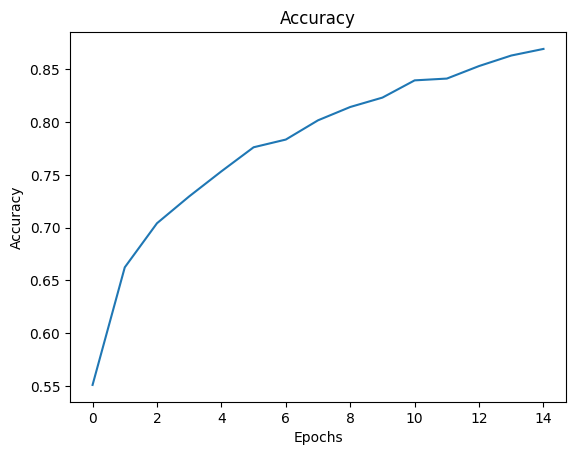

In [ ]:
#Plotting training accuracy curve
plt.title("Accuracy")
plt.plot(result.history["accuracy"])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

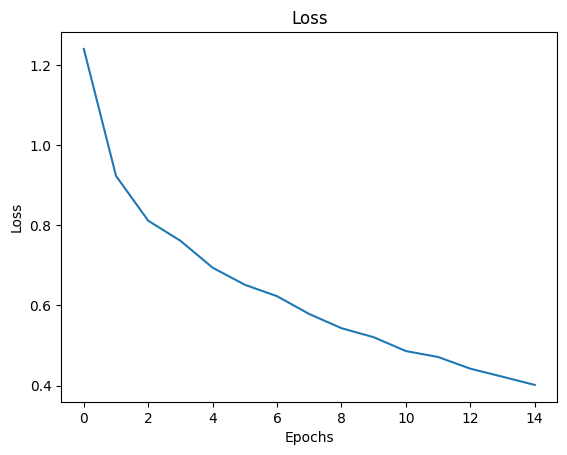

In [ ]:
#Plotting loss curve
plt.title("Loss")
plt.plot(result.history["loss"])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

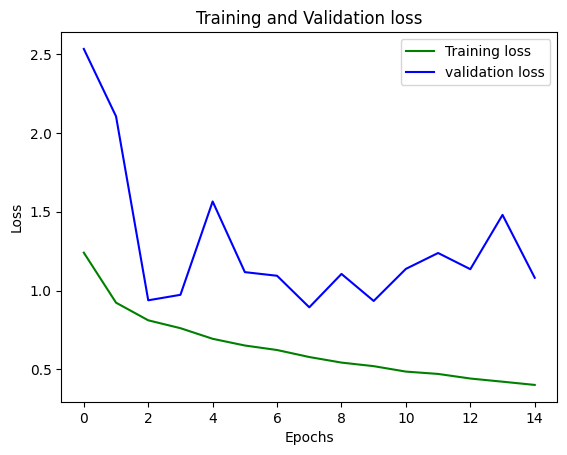

In [ ]:
#Plotting loss vs epoch curve fror training and validation loss
loss_train = result.history['loss']
loss_val = result.history['val_loss']
epochs = range(0,15)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Plotting accuracy vs epoch curve fror training and validation accuracy
loss_train = result.history['accuracy']
loss_val = result.history['val_accuracy']
epochs = range(0,19)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint

# Define your CNN model
def create_model(learning_rate, batch_size, num_filters, kernel_size):
    model = tf.keras.Sequential()
    # 1st layer
    cnn.add(tf.keras.layers.Conv2D(filters=64, padding='same', strides=2, kernel_size=3, activation='relu', input_shape=(28, 28, 3)))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    # 2nd layer
    cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    # 3rd layer
    cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

    cnn.add(tf.keras.layers.Flatten())

    # Last Dense layer
    cnn.add(tf.keras.layers.Dense(8, activation='softmax'))

    return model

# Create a KerasClassifier wrapper for scikit-learn compatibility
model = KerasClassifier(build_fn=create_model)

# Define the hyperparameters and their ranges
param_dist = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_filters': randint(32, 128),
    'kernel_size': [3, 5, 7]
}

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

# Perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3)
random_result = random_search.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[early_stopping])

# Print the best hyperparameters and corresponding performance
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
Palette images with Transparency expressed in bytes should be converted to RGBA images


ValueError: ignored

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

output_class = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"]

def waste_prediction(new_image):
    test_image = tf.keras.preprocessing.image.load_img(new_image, target_size=(224, 224))

    plt.axis("off")
    plt.imshow(test_image)  # Displaying test image
    plt.show()

    test_image = image.img_to_array(test_image) / 255
    test_image = np.expand_dims(test_image, axis=0)

    predicted_array = cnn.predict(test_image)  # Predicting accuracy of test image
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)

    print("Your waste material is ", predicted_value, " with ", predicted_accuracy, " % accuracy")

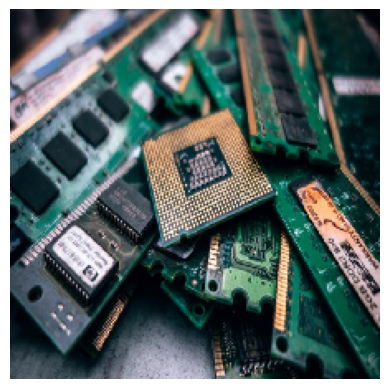

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Your waste material is  ewaste  with  97.36  % accuracy


In [ ]:
image_path = '/content/00000004.jpg'
waste_prediction(image_path)

In [ ]:
# Save the trained model
cnn.save('model.h5')

# Explainability

**LIME**: LIME stands for Local Interpretable Model-agnostic Explanations. It is a Python library based on a paper from Ribeiro et al. to help you understand the behavior of your black-box classifier model. Currently, you can use LIME for a classifier model that classify tabular data, images, or texts.

The abbreviation of LIME itself should give you an intuition about the core idea behind it. LIME is:

**Model agnostic**, which means that LIME is model-independent. In other words, LIME is able to explain any black-box classifier you can think of.

**Interpretable**, which means that LIME provides you a solution to understand why your model behaves the way it does.

**Local,** which means that LIME tries to find the explanation of your black-box model by approximating the local linear behavior of your model.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Define a function to generate the Lime explanation image
def generate_explanation(image_path):
    explainer = lime_image.LimeImageExplainer()
    img = image.load_img(image_path, target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0
    explanation = explainer.explain_instance(img_array, cnn.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    return temp

  0%|          | 0/1000 [00:00<?, ?it/s]

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


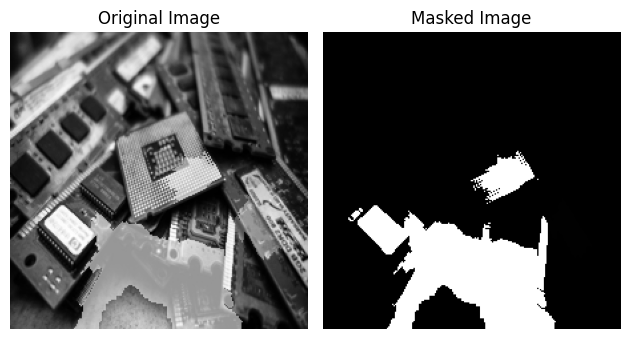

In [ ]:
from PIL import Image
import lime
from lime import lime_image

# Define a function to generate Lime explanations for an image
def generate_explanation(image_path):
    # Create a LimeImageExplainer object
    explainer = lime_image.LimeImageExplainer()

    # Open the image file and resize it to (224, 224)
    img = Image.open(image_path).resize((224, 224))

    # Convert the image to RGB mode
    img = img.convert("RGB")

    # Convert the image to a NumPy array and normalize the pixel values to the range [0, 1]
    img_array = np.array(img) / 255.0

    # Generate the Lime explanation for the image
    explanation = explainer.explain_instance(img_array, cnn.predict, top_labels=3, hide_color=0, num_samples=1000)

    return explanation

# Specify the path to your image file
image_path = '/content/00000004.jpg'

# Generate the Lime explanation for the image
explanation = generate_explanation(image_path)

# Define a function to visualize the Lime explanation
def visualize_explanation(explanation):
    # Check if the explanation has any labels
    if explanation.top_labels:
        # Get the label with the highest score
        label = explanation.top_labels[0]

        # Get the original image and the masked image from the explanation
        original_image, masked_image = explanation.get_image_and_mask(label, positive_only=False, hide_rest=False)

        # Convert the images to grayscale
        original_image = Image.fromarray((original_image * 255).astype(np.uint8)).convert('L')
        masked_image = Image.fromarray((masked_image * 255).astype(np.uint8)).convert('L')

        # Plot the original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Plot the masked image
        plt.subplot(1, 2, 2)
        plt.imshow(masked_image, cmap='gray')
        plt.title('Masked Image')
        plt.axis('off')

        # Display the plot
        plt.tight_layout()
        plt.show()
    else:
        print("No labels found in the explanation.")

# Visualize the Lime explanation
visualize_explanation(explanation)



  0%|          | 0/1000 [00:00<?, ?it/s]

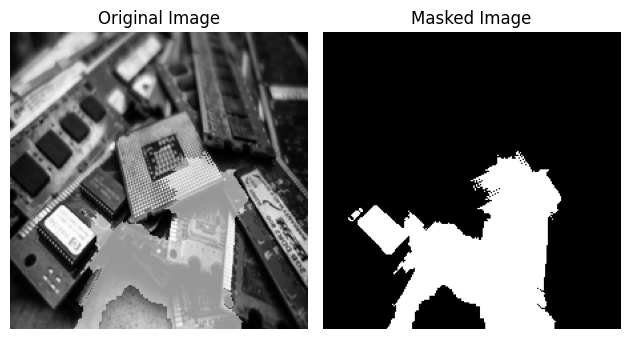

In [ ]:
from PIL import Image
import numpy as np
import lime
from lime import lime_image
import matplotlib.pyplot as plt

# Define a function to generate Lime explanations for an image
def generate_explanation(image_path, model):
    # Create a LimeImageExplainer object
    explainer = lime_image.LimeImageExplainer()

    # Open the image file and resize it to (224, 224)
    img = Image.open(image_path).resize((224, 224))

    # Convert the image to RGB mode
    img = img.convert("RGB")

    # Convert the image to a NumPy array and normalize the pixel values to the range [0, 1]
    img_array = np.array(img) / 255.0

    # Generate the Lime explanation for the image
    explanation = explainer.explain_instance(img_array, model.predict, top_labels=3, hide_color=0, num_samples=1000)

    return explanation

# Define a function to visualize the Lime explanation
def visualize_explanation(explanation):
    # Check if the explanation has any labels
    if explanation.top_labels:
        # Get the label with the highest score
        label = explanation.top_labels[0]

        # Get the original image and the masked image from the explanation
        original_image, masked_image = explanation.get_image_and_mask(label, positive_only=False, hide_rest=False)

        # Convert the images to grayscale
        original_image = Image.fromarray((original_image * 255).astype(np.uint8)).convert('L')
        masked_image = Image.fromarray((masked_image * 255).astype(np.uint8)).convert('L')

        # Save the masked image
        masked_image_path = '/content/masked_image.jpg'
        masked_image.save(masked_image_path)

        # Plot the original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Plot the masked image
        plt.subplot(1, 2, 2)
        plt.imshow(masked_image, cmap='gray')
        plt.title('Masked Image')
        plt.axis('off')

        masked_image_path = 'masked_image.jpg'
        # Display the plot
        plt.tight_layout()
        plt.show()
    else:
        print("No labels found in the explanation.")

# Specify the path to your image file
image_path = '/content/00000004.jpg'

# Generate the Lime explanation for the image using the cnn model
explanation = generate_explanation(image_path, cnn)

# Visualize the Lime explanation
visualize_explanation(explanation)


In [ ]:
# Specify the path to your original image file
original_image_path = '/content/00000004.jpg'

# Generate the Lime explanation for the original image using the black-box model
original_explanation = generate_explanation(original_image_path, cnn)

# Specify the path to your masked image file
masked_image_path = '/content/masked_image.jpg'

# Generate the Lime explanation for the masked image using the black-box model
masked_explanation = generate_explanation(masked_image_path, cnn)

def preprocess_image(image):
    # Resize the image to (224, 224)
    resized_image = tf.image.resize(image, (224, 224))

    # Convert the pixel values to the range [0, 1]
    normalized_image = resized_image / 255.0

    return normalized_image

def calculate_fidelity(explanation, black_box_model):
    # Preprocess the original image
    original_image = preprocess_image(explanation.image)

    # Add an extra dimension to match the expected input shape of the black-box model
    original_image = tf.expand_dims(original_image, axis=0)

    # Get the predicted probabilities from the black-box model for the original image
    original_prediction = black_box_model.predict(original_image, steps=1)

    # Preprocess the masked image
    masked_image = explanation.image * explanation.segments[..., np.newaxis]

    # Add an extra dimension to match the expected input shape of the black-box model
    masked_image = tf.expand_dims(masked_image, axis=0)

    # Get the predicted probabilities from the black-box model for the masked image
    masked_prediction = black_box_model.predict(masked_image, steps=1)

    # Calculate the fidelity as the cosine similarity between the original and masked predictions
    similarity = np.dot(original_prediction, masked_prediction.T) / (np.linalg.norm(original_prediction) * np.linalg.norm(masked_prediction))
    fidelity = similarity.item()

    return fidelity

def calculate_stability(explanation1, explanation2, black_box_model):
    # Preprocess the first masked image
    masked_image1 = explanation1.image * explanation1.segments[..., np.newaxis]

    # Add an extra dimension to match the expected input shape of the black-box model
    masked_image1 = tf.expand_dims(masked_image1, axis=0)

    # Get the predicted probabilities from the black-box model for the first masked image
    prediction1 = black_box_model.predict(masked_image1, steps=1)

    # Preprocess the second masked image
    masked_image2 = explanation2.image * explanation2.segments[..., np.newaxis]

    # Add an extra dimension to match the expected input shape of the black-box model
    masked_image2 = tf.expand_dims(masked_image2, axis=0)

    # Get the predicted probabilities from the black-box model for the second masked image
    prediction2 = black_box_model.predict(masked_image2, steps=1)

    # Calculate the stability as the cosine similarity between the predictions of the two masked images
    similarity = np.dot(prediction1, prediction2.T) / (np.linalg.norm(prediction1) * np.linalg.norm(prediction2))
    stability = similarity.item()

    return stability

# Calculate fidelity
fidelity = calculate_fidelity(original_explanation, cnn)

# Calculate stability
stability = calculate_stability(original_explanation, masked_explanation, cnn)

# Print the fidelity and stability values
print("Fidelity:", fidelity)
print("Stability:", stability)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fidelity: 0.7086465358734131
Stability: 0.00014529016334563494


In [ ]:
# Specify the path to your image file
image_path = '/content/00000004.jpg'

# Generate the Lime explanation for the image
explanation = generate_explanation(image_path)

# Calculate the faithfulness value
faithfulness = calculate_faithfulness(explanation)

# Print the faithfulness value
print("Faithfulness:", faithfulness)


  0%|          | 0/1000 [00:00<?, ?it/s]

AttributeError: ignored

In [ ]:
from PIL import Image
import lime
from lime import lime_image

# Define a function to generate Lime explanations for an image
def generate_explanation(image_path):
    # Create a LimeImageExplainer object
    explainer = lime_image.LimeImageExplainer()

    # Open the image file and resize it to (224, 224)
    img = Image.open(image_path).resize((224, 224))

    # Convert the image to RGB mode
    img = img.convert("RGB")

    # Convert the image to a NumPy array and normalize the pixel values to the range [0, 1]
    img_array = np.array(img) / 255.0

    # Generate the Lime explanation for the image
    explanation = explainer.explain_instance(img_array, cnn.predict, top_labels=1, hide_color=0, num_samples=1000)

    return explanation

# Specify the path to your image file
image_path = '/content/00000004.jpg'

# Generate the Lime explanation for the image
explanation_image = generate_explanation(image_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

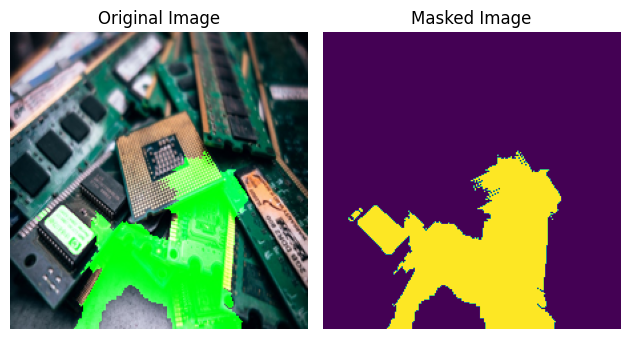

In [ ]:
import matplotlib.pyplot as plt

# Define a function to visualize the Lime explanation
def visualize_explanation(explanation):
    # Check if the explanation has any labels
    if explanation.top_labels:
        # Get the label with the highest score
        label = explanation.top_labels[0]

        # Get the original image and the masked image from the explanation
        original_image, masked_image = explanation.get_image_and_mask(label, positive_only=False, hide_rest=False)

        # Plot the original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')

        # Plot the masked image
        plt.subplot(1, 2, 2)
        plt.imshow(masked_image)
        plt.title('Masked Image')
        plt.axis('off')

        # Display the plot
        plt.tight_layout()
        plt.show()
    else:
        print("No labels found in the explanation.")

# Visualize the Lime explanation image
visualize_explanation(explanation_image)


In [ ]:
# Get the predicted probabilities from the CNN model
img_array = np.array(Image.open(image_path).resize((224, 224))) / 255.0
predicted_probabilities = cnn.predict(np.expand_dims(img_array, axis=0))[0]

# Get the explanation probabilities from Lime
explanation_probabilities = explanation.local_exp[0]

# Calculate fidelity
fidelity = np.sum(predicted_probabilities * explanation_probabilities)

ValueError: ignored

**SHAP**

In [ ]:
sample_images = []
sample_labels = []

for _ in range(10):  # Change the number of samples as needed
    image, label = next(valid_gen)
    sample_images.append(image[0])
    sample_labels.append(label[0])

sample_images = np.array(sample_images)
sample_labels = np.argmax(np.array(sample_labels), axis=1)  # Convert one-hot encoded labels to class indices


In [ ]:
train_gen

In [ ]:
explainer = shap.GradientExplainer(cnn, train_gen[0][0])

In [ ]:
shap_values = explainer.shap_values(sample_images)

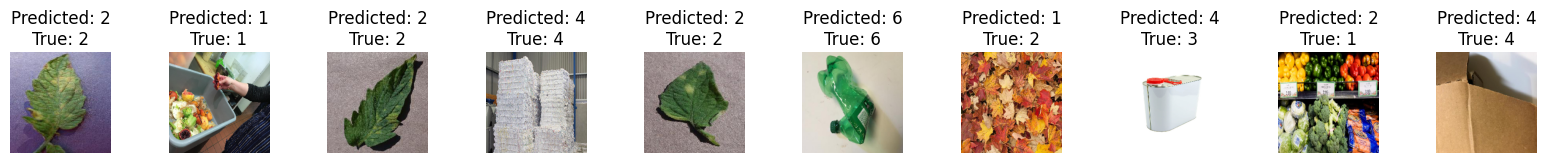

In [ ]:
import matplotlib.pyplot as plt

# Reshape sample_images to (num_samples, 224, 224, 3)
sample_images_reshaped = sample_images.reshape((-1, 224, 224, 3))

# Get model predictions for the sample images
predictions = cnn.predict(sample_images_reshaped)
predicted_labels = np.argmax(predictions, axis=1)

# Plot the images, predicted labels, and true labels
fig, axes = plt.subplots(ncols=len(sample_images_reshaped), figsize=(16, 8))
fig.tight_layout()

for i, (image, predicted_label, true_label) in enumerate(zip(sample_images_reshaped, predicted_labels, sample_labels)):
    # Plot the predicted image
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f'Predicted: {predicted_label}\nTrue: {true_label}')

plt.show()


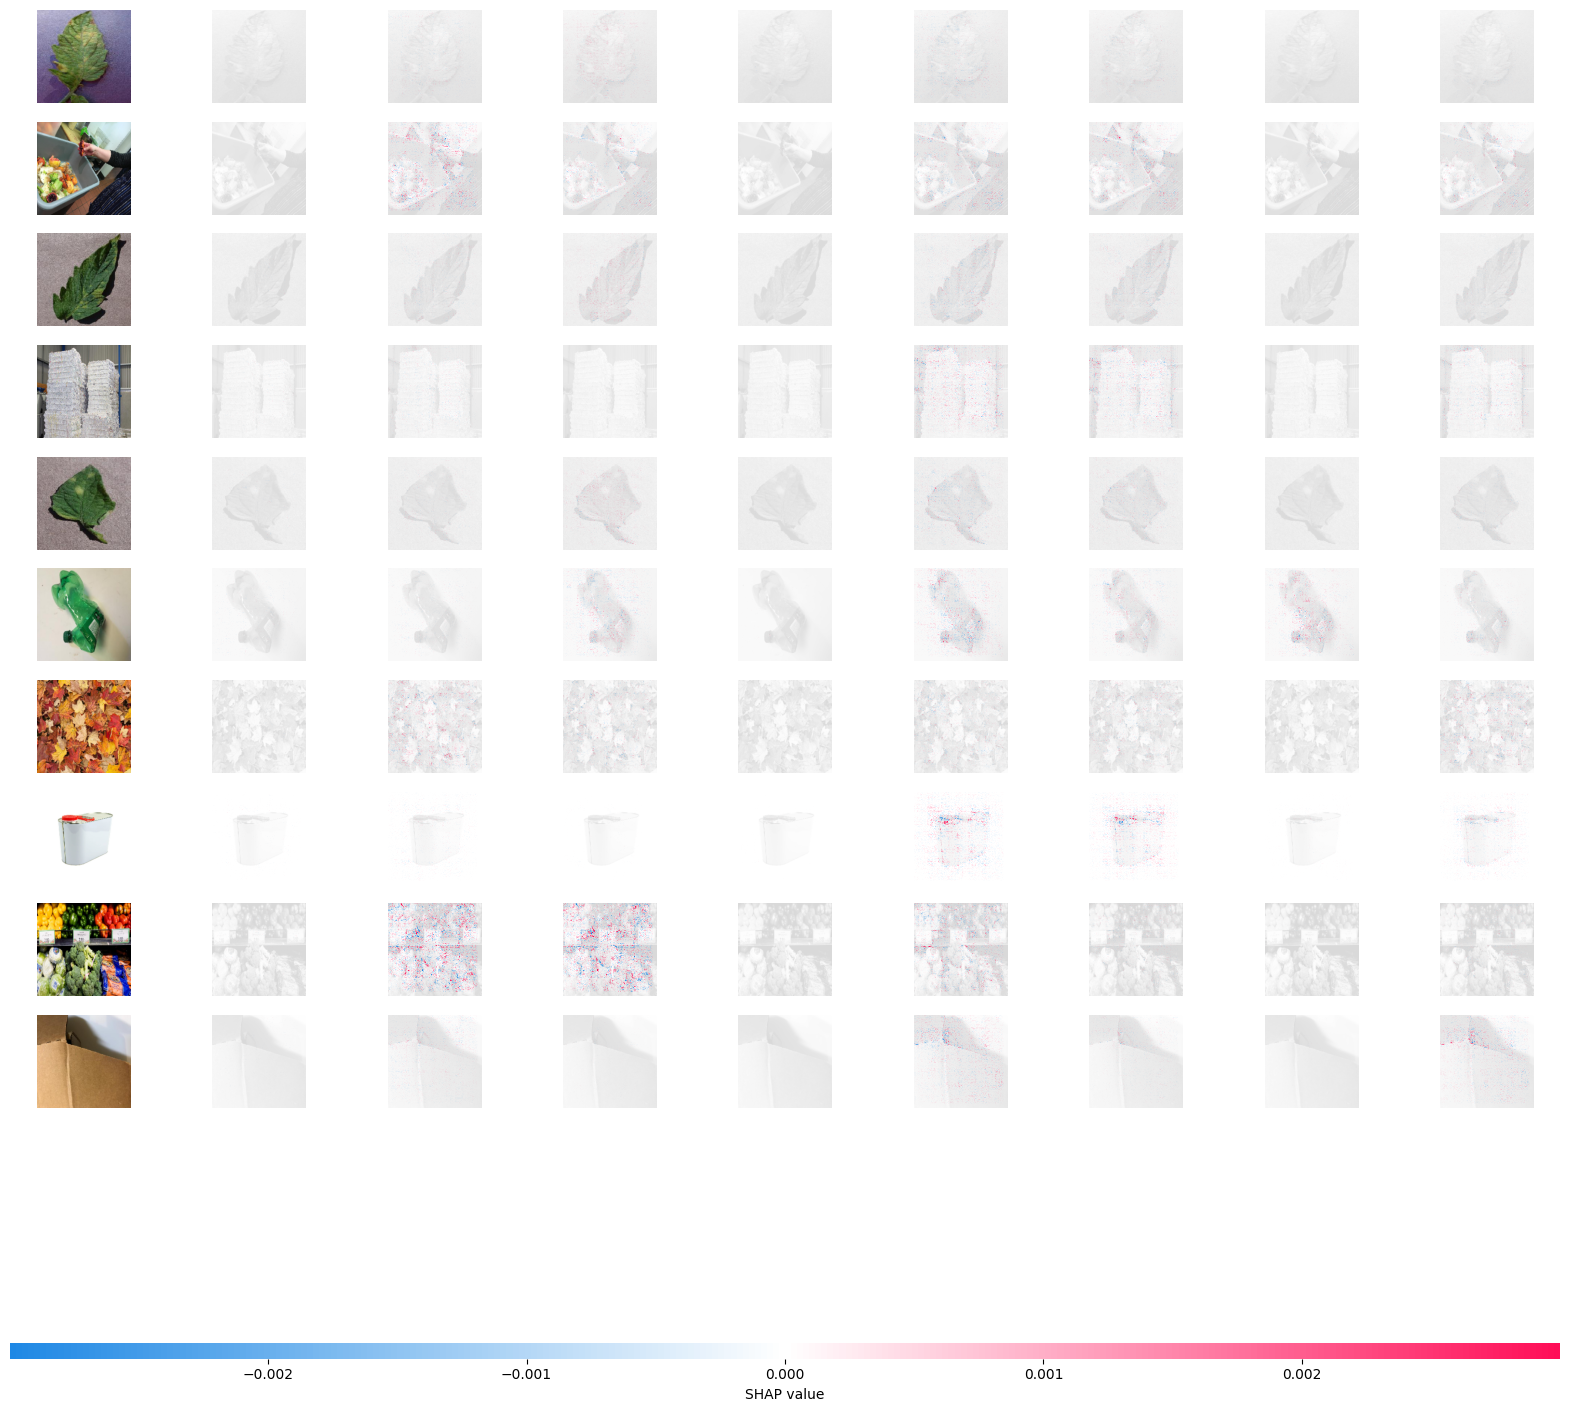

In [ ]:
# Plot the explanations
shap.image_plot(shap_values, sample_images)

In this visualization:

Red pixels represent positive SHAP values that contributed to classifying that image as that particular class.

Blue pixels represent negative SHAP values that contributed to not classifying that image as that particular class.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Convert the list of SHAP values to a NumPy array
shap_values_array = np.array(shap_values)

# Reshape the SHAP values array to match the number of samples
shap_values_reshaped = shap_values_array[:len(sample_images)].reshape((-1, 224, 224, 3))

# Tile the reshaped SHAP values array to match the number of samples
shap_values_tiled = np.tile(shap_values_reshaped, (len(sample_images), 1, 1, 1))

# Calculate the predictions using SHAP values
sample_images_with_shap = sample_images + shap_values_tiled[:len(sample_images)]

# Get model predictions for the sample images with SHAP values
predictions_shap = cnn.predict(sample_images_with_shap)
predicted_labels_shap = np.argmax(predictions_shap, axis=1)

# Fidelity: Calculate the accuracy between original predictions and predictions using SHAP values
fidelity = accuracy_score(sample_labels, predicted_labels_shap)

# Print the fidelity
print("Fidelity:", fidelity)


Fidelity: 0.7


In [ ]:
# Stability: Calculate the agreement between original predictions and predictions using SHAP values
stability = np.mean(sample_labels == predicted_labels_shap)

# Print the stability
print("Stability:", stability)

# Importance Ranking: Calculate the importance ranking based on SHAP values
importance_ranking = np.mean(np.abs(shap_values_reshaped), axis=(0, 1, 2,))

# Sort the features based on importance ranking
sorted_features = np.argsort(importance_ranking)[::-1]

# Print the importance ranking
print("Importance Ranking:")
for i, feature_index in enumerate(sorted_features):
    print(f"Feature {i+1}: Index {feature_index}, Importance {importance_ranking[feature_index]}")


Stability: 0.7
Importance Ranking:
Feature 1: Index 2, Importance 5.689935469816719e-05
Feature 2: Index 1, Importance 5.344717172778154e-05
Feature 3: Index 0, Importance 5.07216230018571e-05


In [ ]:
!pip install pdpbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.0/570.0 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: docutils
    Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 3.5.4
    Uninstalling Sphinx-3.5.4:
      Successfully uninstalled Sphinx-3.5.4


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import pdpbox
from pdpbox import pdp, info_plots
import matplotlib.pyplot as plt

# Load the trained model and the validation data
model = cnn  # Use your trained CNN model here
X_val = valid_gen[0][0]  # Extract the features from the validation data

# Assuming your CNN model takes input of shape (224, 224, 3), reshape the features accordingly
X_val_reshaped = X_val.reshape(-1, 224, 224, 3)
feature_names = ['feature_{}'.format(i) for i in range(X_val_reshaped.shape[1] * X_val_reshaped.shape[2] * X_val_reshaped.shape[3])]
X_val_df = pd.DataFrame(X_val_reshaped.reshape(X_val_reshaped.shape[0], -1), columns=feature_names)

# Select a sample from the validation data to generate the PDPs
sample_idx = 0  # Choose the index of the sample from the validation data

# Select a feature to generate the PDP for
selected_feature = 'feature_0'  # Choose the feature name

# Calculate the predictions for the selected sample
pred_func = lambda x: model.predict_proba(x)[:, 1]
base_value = pred_func(X_val_reshaped[[sample_idx]])

# Generate the PDP
pdp_feature = pdp_isolate(model=model, dataset=X_val_df, model_features=feature_names, feature=selected_feature)

# Plot the isolated PDP for the selected feature
pdp_isolate_plot(pdp_feature, feature_name=selected_feature)
plt.show()


AttributeError: ignored

In [ ]:
from pdpbox import pdp, get_dataset
# Function to get model predictions
def predict_fn(X):
    return cnn.predict(X)

# Calculate PDP for a specific feature
feature_to_plot = 'conv2d'
pdp_feature = pdp.pdp_isolate(
    model=cnn,
    dataset=X_val,
    model_features=train_generator.class_indices.keys(),
    feature=feature_to_plot,
    predict_fn=predict_fn
)

# Plot the PDP
pdp.pdp_plot(pdp_feature, feature_to_plot)

ImportError: ignored

In [ ]:
model = cnn  # Use your trained CNN model here
X_val = valid_gen[0][0]  # Extract the features from the validation data


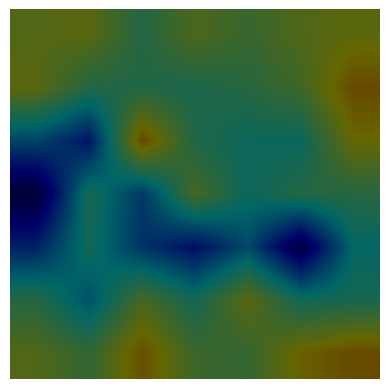

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def generate_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap

def generate_grad_cam_animation(model, img_array):
    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

    # Create a TensorFlow session
    session = tf.compat.v1.keras.backend.get_session()

    # Initialize the figure and axes
    fig, ax = plt.subplots()
    ax.axis('off')

    # Generate Grad-CAM images for each layer and animate them
    ims = []
    for layer_name in layer_names:
        heatmap = generate_grad_cam(model, img_array, layer_name=layer_name)
        heatmap_np = session.run(heatmap)

        heatmap_resized = cv2.resize(heatmap_np, (img_array.shape[2], img_array.shape[1]))
        heatmap_rescaled = np.uint8(255 * heatmap_resized)
        heatmap_colormap = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)
        img_array_uint8 = img_array.astype('uint8')
        superimposed_img = cv2.addWeighted(cv2.cvtColor(img_array_uint8[0], cv2.COLOR_RGB2BGR), 0.6, heatmap_colormap, 0.4, 0)

        # Display the superimposed image
        im = ax.imshow(superimposed_img)
        ims.append([im])

    # Animate the images
    anim = FuncAnimation(fig, update_image, frames=len(ims), fargs=(ims,), interval=1000, repeat=True)

    # Show the animation
    plt.show()

def update_image(frame, ims):
    for im in ims:
        im[0].set_array(superimposed_img)
    return ims

# Specify the path to your image file
image_path = '/content/00000004.jpg'

# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Generate Grad-CAM animation for each layer
generate_grad_cam_animation(cnn, img_array)


# Robustness-ART Classifier

**Evasion Attack**: Evasion attacks typically work by perturbing input data to cause a trained model to misclassify it. Evasion is done after training and during inference, i.e. when models are already deployed in production. Adversaries perform evasion attacks to avoid detection by AI systems. As an example, adversaries might run an evasion attack to cause the victim model to miss phishing emails. Evasion attacks might require access to the victim model.

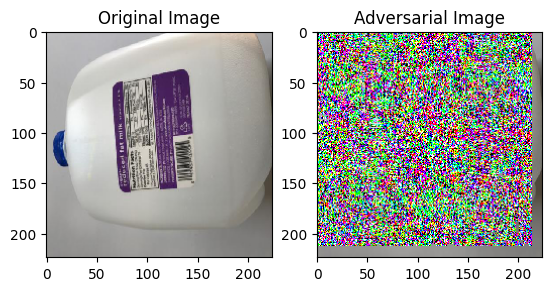

Clean Accuracy: 0.71875
Adversarial Accuracy: 0.046875
Clean Loss: 0.125
Adversarial Loss: 0.12499998


In [ ]:
# Create a classifier using the trained model
classifier = KerasClassifier(model=cnn, clip_values=(0, 1))

# Define an attack using the Fast Gradient Method
attack = FastGradientMethod(estimator=classifier, eps=1)

# Generate adversarial images from valid_gen
x_valid, y_valid = valid_gen.next()
x_valid_adv = attack.generate(x=x_valid, y=y_valid)

# View an adversarial image
index = 0  # Choose an index of the adversarial image to view

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(x_valid[index])
plt.title('Original Image')

# Display the adversarial image
plt.subplot(1, 2, 2)
plt.imshow(x_valid_adv[index])
plt.title('Adversarial Image')

plt.show()

# Evaluate the model on clean images
clean_preds = classifier.predict(x=x_valid)
clean_acc = np.mean(np.argmax(clean_preds, axis=1) == np.argmax(y_valid, axis=1))

# Evaluate the model on adversarial images
adv_preds = classifier.predict(x=x_valid_adv)
adv_acc = np.mean(np.argmax(adv_preds, axis=1) == np.argmax(y_valid, axis=1))

# Compare test losses
clean_loss = np.mean(classifier.predict(x_valid, batch_size=128)[0])
adv_loss = np.mean(classifier.predict(x_valid_adv, batch_size=128)[0])

# Compare test accuracies
print('Clean Accuracy:', clean_acc)
print('Adversarial Accuracy:', adv_acc)
print('Clean Loss:', clean_loss)
print('Adversarial Loss:', adv_loss)


In [ ]:
# Apply defense technique - Adversarial Training
adv_trainer = AdversarialTrainer(classifier, attack)

# Train the classifier using adversarial examples
adv_trainer.fit(x=x_valid_adv, y=y_valid, nb_epochs=10)

# Evaluate the model on clean images
clean_preds = classifier.predict(x=x_valid)
clean_acc = np.mean(np.argmax(clean_preds, axis=1) == np.argmax(y_valid, axis=1))

# Evaluate the model on adversarial images
adv_preds = classifier.predict(x=x_valid_adv)
adv_acc = np.mean(np.argmax(adv_preds, axis=1) == np.argmax(y_valid, axis=1))

# Compare test accuracies
print('Clean Accuracy:', clean_acc)
print('Adversarial Accuracy:', adv_acc)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Clean Accuracy: 0.34375
Adversarial Accuracy: 0.265625


In [ ]:
# Save the weights of the original model
cnn.save_weights('/tmp/original_model_weights.h5')

# Define the distillation model with the same architecture as the original model
distillation_model = tf.keras.Sequential()
distillation_model.add(tf.keras.layers.Conv2D(filters=64, padding='same', strides=2, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
distillation_model.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3, activation='relu'))
distillation_model.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3, activation='relu'))
distillation_model.add(tf.keras.layers.Flatten())
distillation_model.add(tf.keras.layers.Dense(8, activation='softmax'))

# Compile the distillation model
distillation_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the distillation model on the clean data
distillation_model.fit(train_gen, epochs=10, validation_data=valid_gen)

# Load the weights of the original model
cnn.load_weights('/tmp/original_model_weights.h5')

# Apply defensive distillation
temperature = 3  # Temperature parameter for distillation
x_train_distill = distillation_model.predict(train_gen) / temperature
y_train_distill = train_gen.labels

# Combine the original and distilled data
x_combined = np.concatenate((train_gen, x_train_distill), axis=0)
y_combined = np.concatenate((train_gen.labels, y_train_distill), axis=0)

# Retrain the model on the combined data
cnn.fit(x_combined, y_combined, epochs=10, validation_data=(x_valid, y_valid))

# Evaluate the model on clean images
clean_preds = classifier.predict(x=x_valid)
clean_acc = np.mean(np.argmax(clean_preds, axis=1) == np.argmax(y_valid, axis=1))

# Evaluate the model on adversarial images
adv_preds = classifier.predict(x=x_valid_adv)
adv_acc = np.mean(np.argmax(adv_preds, axis=1) == np.argmax(y_valid, axis=1))

# Compare test accuracies
print('Clean Accuracy:', clean_acc)
print('Adversarial Accuracy:', adv_acc)


Epoch 1/10
 28/148 [====>.........................] - ETA: 4:41 - batch: 13.5000 - size: 64.0000 - loss: 1.7035 - accuracy: 0.3337

Palette images with Transparency expressed in bytes should be converted to RGBA images


148/148 [==============================] - ETA: 0s - batch: 73.5000 - size: 63.7297 - loss: 1.2715 - accuracy: 0.5283

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


148/148 [==============================] - 398s 3s/step - batch: 73.5000 - size: 63.7297 - loss: 1.2715 - accuracy: 0.5283 - val_loss: 1.1369 - val_accuracy: 0.5620
Epoch 2/10
148/148 [==============================] - 355s 2s/step - batch: 73.5000 - size: 63.7297 - loss: 0.9933 - accuracy: 0.6363 - val_loss: 0.9243 - val_accuracy: 0.6878
Epoch 3/10
148/148 [==============================] - 357s 2s/step - batch: 73.5000 - size: 63.7297 - loss: 0.8637 - accuracy: 0.6899 - val_loss: 1.0267 - val_accuracy: 0.6470
Epoch 4/10
148/148 [==============================] - 355s 2s/step - batch: 73.5000 - size: 63.7297 - loss: 0.7404 - accuracy: 0.7330 - val_loss: 0.9898 - val_accuracy: 0.6869
Epoch 5/10
148/148 [==============================] - 358s 2s/step - batch: 73.5000 - size: 63.7297 - loss: 0.5816 - accuracy: 0.7945 - val_loss: 1.0340 - val_accuracy: 0.6928
Epoch 6/10
148/148 [==============================] - 358s 2s/step - batch: 73.5000 - size: 63.7297 - loss: 0.4415 - accuracy: 0.84

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Create a classifier using the trained model
classifier = KerasClassifier(model=cnn, clip_values=(0, 1))

# Define an attack using the Fast Gradient Method
attack = FastGradientMethod(estimator=classifier, eps=1)

# Generate adversarial images from valid_gen
x_valid, y_valid = valid_gen.next()
x_valid_adv = attack.generate(x=x_valid, y=y_valid)

# Evaluate the model on clean images
clean_preds = classifier.predict(x=x_valid)
clean_acc = np.mean(np.argmax(clean_preds, axis=1) == np.argmax(y_valid, axis=1))
clean_loss = np.mean(clean_preds[0])

# Evaluate the model on adversarial images
adv_preds = classifier.predict(x=x_valid_adv)
adv_acc = np.mean(np.argmax(adv_preds, axis=1) == np.argmax(y_valid, axis=1))
adv_loss = np.mean(adv_preds[0])

# Compare test accuracies
print('Clean Accuracy:', clean_acc)
print('Adversarial Accuracy:', adv_acc)
print('Clean Loss:', clean_loss)
print('Adversarial Loss:', adv_loss)

# Randomly select 20 images from the validation set
indices = np.random.choice(len(x_valid), size=20, replace=False)
x_sample = x_valid[indices]
y_sample = y_valid[indices]

# Generate adversarial images for the sample
x_sample_adv = attack.generate(x=x_sample, y=y_sample)

# Evaluate the model on the sample of images
sample_clean_preds = classifier.predict(x=x_sample)
sample_clean_acc = np.mean(np.argmax(sample_clean_preds, axis=1) == np.argmax(y_sample, axis=1))
sample_clean_loss = np.mean(sample_clean_preds[0])

sample_adv_preds = classifier.predict(x=x_sample_adv)
sample_adv_acc = np.mean(np.argmax(sample_adv_preds, axis=1) == np.argmax(y_sample, axis=1))
sample_adv_loss = np.mean(sample_adv_preds[0])

# Calculate additional evaluation metrics
sample_clean_pred_labels = np.argmax(sample_clean_preds, axis=1)
sample_adv_pred_labels = np.argmax(sample_adv_preds, axis=1)
sample_true_labels = np.argmax(y_sample, axis=1)

# Confusion matrix
confusion_mat = confusion_matrix(sample_true_labels, sample_clean_pred_labels)
print('Confusion Matrix (Clean Images):')
print(confusion_mat)

# Precision, Recall, and F1 Score
precision = precision_score(sample_true_labels, sample_clean_pred_labels, average='weighted')
recall = recall_score(sample_true_labels, sample_clean_pred_labels, average='weighted')
f1 = f1_score(sample_true_labels, sample_clean_pred_labels, average='weighted')
print('Precision (Clean Images):', precision)
print('Recall (Clean Images):', recall)
print('F1 Score (Clean Images):', f1)

# Classification Report
classification_rep = classification_report(sample_true_labels, sample_clean_pred_labels)
print('Classification Report (Clean Images):')
print(classification_rep)

# Repeat for adversarial images
adv_confusion_mat = confusion_matrix(sample_true_labels, sample_adv_pred_labels)
print('Confusion Matrix (Adversarial Images):')
print(adv_confusion_mat)

adv_precision = precision_score(sample_true_labels, sample_adv_pred_labels, average='weighted')
adv_recall = recall_score(sample_true_labels, sample_adv_pred_labels, average='weighted')
adv_f1 = f1_score(sample_true_labels, sample_adv_pred_labels, average='weighted')
print('Precision (Adversarial Images):', adv_precision)
print('Recall (Adversarial Images):', adv_recall)
print('F1 Score (Adversarial Images):', adv_f1)

adv_classification_rep = classification_report(sample_true_labels, sample_adv_pred_labels)
print('Classification Report (Adversarial Images):')
print(adv_classification_rep)


Clean Accuracy: 0.65625
Adversarial Accuracy: 0.0
Clean Loss: 0.125
Adversarial Loss: 0.124999985
Confusion Matrix (Clean Images):
[[0 0 0 0 0 0 0 0]
 [0 3 0 0 0 1 0 1]
 [0 0 5 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 2 0]
 [0 0 0 0 0 0 0 2]]
Precision (Clean Images): 0.8166666666666667
Recall (Clean Images): 0.7
F1 Score (Clean Images): 0.7158333333333333
Classification Report (Clean Images):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.60      0.75         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         1
           4       0.33      0.50      0.40         2
           5       0.33      1.00      0.50         1
           6       1.00      0.50      0.67         4
           7       0.67      1.00      0.80         2

    accuracy                           0.70        20
   macro avg       0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Epsilon: 0.1
Clean Accuracy: 0.609375
Adversarial Accuracy: 0.0
Clean Loss: 0.125
Adversarial Loss: 0.12499998

Epsilon: 0.2
Clean Accuracy: 0.609375
Adversarial Accuracy: 0.0
Clean Loss: 0.125
Adversarial Loss: 0.124999985

Epsilon: 0.3
Clean Accuracy: 0.609375
Adversarial Accuracy: 0.0
Clean Loss: 0.125
Adversarial Loss: 0.12500001

Epsilon: 0.4
Clean Accuracy: 0.609375
Adversarial Accuracy: 0.0
Clean Loss: 0.125
Adversarial Loss: 0.124999985

Epsilon: 0.5
Clean Accuracy: 0.609375
Adversarial Accuracy: 0.0
Clean Loss: 0.125
Adversarial Loss: 0.125

Epsilon: 0.6
Clean Accuracy: 0.609375
Adversarial Accuracy: 0.0
Clean Loss: 0.125
Adversarial Loss: 0.125

Epsilon: 0.7
Clean Accuracy: 0.609375
Adversarial Accuracy: 0.0
Clean Loss: 0.125
Adversarial Loss: 0.124999985



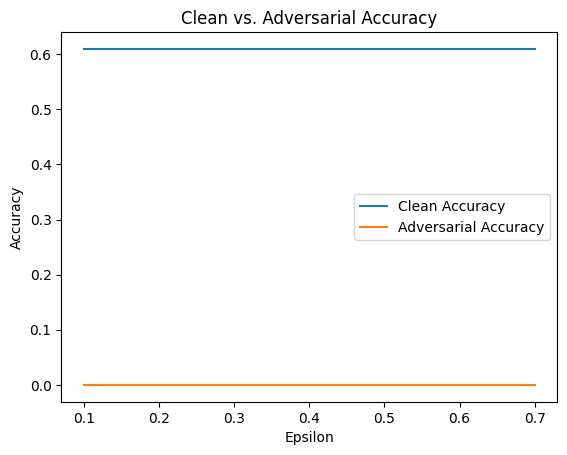

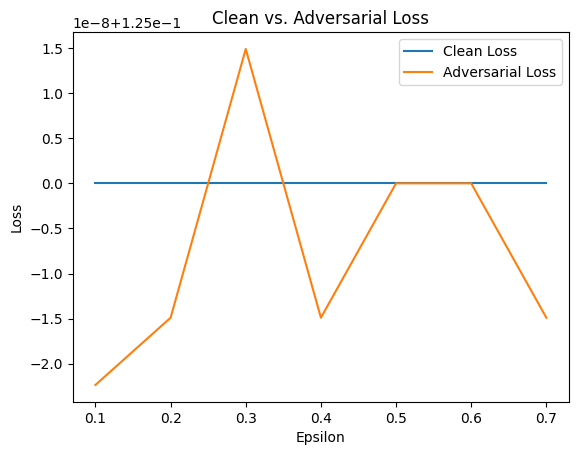

In [ ]:
# Set random seed for reproducibility
np.random.seed(123)

# Define a list of epsilon values to try
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

# Create lists to store clean and adversarial accuracies and losses
clean_acc_list = []
adv_acc_list = []
clean_loss_list = []
adv_loss_list = []

# Generate and evaluate the adversarial images for each epsilon value
for eps in eps_values:
    # Create the FastGradientMethod attack object with the current epsilon value
    fgm = FastGradientMethod(estimator=classifier, eps=eps)

    # Generate the adversarial images using FGM with the current epsilon value
    x_valid_adv = fgm.generate(x=x_valid, y=y_valid)

    # Clip the adversarial images to the valid range (0, 1)
    x_valid_adv = np.clip(x_valid_adv, 0, 1)

    # Evaluate the model on clean images
    clean_preds = classifier.predict(x=x_valid)
    clean_acc = np.mean(np.argmax(clean_preds, axis=1) == np.argmax(y_valid, axis=1))
    clean_loss = np.mean(classifier.predict(x=x_valid, batch_size=128)[0])  # Use index 0 for loss calculation

    # Evaluate the model on adversarial images
    adv_preds = classifier.predict(x=x_valid_adv)
    adv_acc = np.mean(np.argmax(adv_preds, axis=1) == np.argmax(y_valid, axis=1))
    adv_loss = np.mean(classifier.predict(x=x_valid_adv, batch_size=128)[0])  # Use index 0 for loss calculation

    # Append accuracy and loss values to the respective lists
    clean_acc_list.append(clean_acc)
    adv_acc_list.append(adv_acc)
    clean_loss_list.append(clean_loss)
    adv_loss_list.append(adv_loss)

    # Print clean and adversarial accuracy and loss values
    print('Epsilon:', eps)
    print(f"Clean Accuracy:", clean_acc)
    print(f"Adversarial Accuracy:", adv_acc)
    print(f"Clean Loss:", clean_loss)
    print(f"Adversarial Loss:", adv_loss)
    print()

# Plot a comparison graph for clean and adversarial accuracies
plt.plot(eps_values, clean_acc_list, label='Clean Accuracy')
plt.plot(eps_values, adv_acc_list, label='Adversarial Accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Clean vs. Adversarial Accuracy')
plt.legend()
plt.show()

# Plot a comparison graph for clean and adversarial losses
plt.plot(eps_values, clean_loss_list, label='Clean Loss')
plt.plot(eps_values, adv_loss_list, label='Adversarial Loss')
plt.xlabel('Epsilon')
plt.ylabel('Loss')
plt.title('Clean vs. Adversarial Loss')
plt.legend()
plt.show()


In [ ]:
!pip install adversarial-robustness-toolbox

The Carlini and Wagner (C&W) attack is a type of adversarial attack designed to generate adversarial examples that can fool machine learning models. It aims to find the minimum perturbation on input samples that causes the model to misclassify the samples while keeping the perturbations imperceptible to human eyes.

The C&W attack formulates the problem as an optimization task by introducing an objective function that simultaneously minimizes the perturbation magnitude and maximizes the model's misclassification confidence. The objective function consists of two terms: the first term controls the perturbation magnitude, and the second term encourages the misclassification.

The attack algorithm starts with an initial adversarial sample and iteratively updates it to find a better adversarial example. It employs optimization techniques such as gradient descent to minimize the objective function while considering constraints on the perturbation size and pixel values.

During each iteration, the attack modifies the adversarial sample by adding small perturbations to its pixel values. The perturbations are constrained to be within a certain distance (e.g., L2 distance) from the original sample to ensure imperceptibility. The attack also incorporates a binary search to find the optimal perturbation magnitude that satisfies the misclassification constraint while minimizing the perturbation size.

By optimizing the objective function and iteratively refining the adversarial sample, the C&W attack aims to find adversarial examples that are highly effective in fooling the target model. These adversarial examples can reveal vulnerabilities and weaknesses in machine learning models, highlighting the need for robustness and defense mechanisms against adversarial attacks.

C&W L_2:   0%|          | 0/320 [00:00<?, ?it/s]

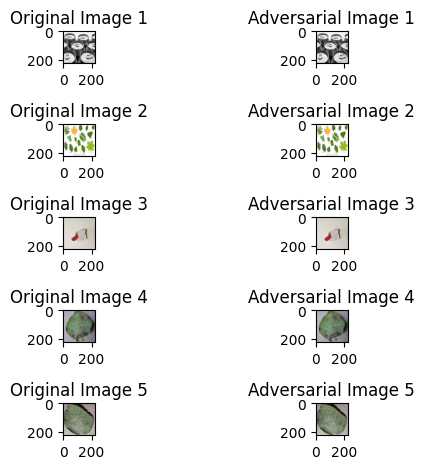

Clean Accuracy: 0.70625
Adversarial Accuracy: 0.140625
Clean Loss: 0.12499999
Adversarial Loss: 0.12499999


In [ ]:
from art.attacks.evasion import CarliniL2Method
from art.estimators.classification import KerasClassifier

# Create a classifier using the trained model
classifier = KerasClassifier(model=cnn, clip_values=(0, 1))

# Define an attack using the Carlini and Wagner (C&W) attack
attack = CarliniL2Method(classifier, targeted=False)

# Generate adversarial images from valid_gen for only 5 samples
num_samples = 5
x_valid, y_valid = [], []

for _ in range(num_samples):
    x, y = valid_gen.next()
    x_valid.append(x)
    y_valid.append(y)

x_valid = np.concatenate(x_valid, axis=0)
y_valid = np.concatenate(y_valid, axis=0)

x_valid_adv = attack.generate(x=x_valid, y=y_valid)

# View adversarial images
for i in range(num_samples):
    # Display the original image
    plt.subplot(num_samples, 2, i * 2 + 1)
    plt.imshow(x_valid[i])
    plt.title(f'Original Image {i+1}')

    # Display the adversarial image
    plt.subplot(num_samples, 2, i * 2 + 2)
    plt.imshow(x_valid_adv[i])
    plt.title(f'Adversarial Image {i+1}')

plt.tight_layout()
plt.show()

# Evaluate the model on clean images
clean_preds = classifier.predict(x=x_valid)
clean_acc = np.mean(np.argmax(clean_preds, axis=1) == np.argmax(y_valid, axis=1))

# Evaluate the model on adversarial images
adv_preds = classifier.predict(x=x_valid_adv)
adv_acc = np.mean(np.argmax(adv_preds, axis=1) == np.argmax(y_valid, axis=1))

# Compare test losses
clean_loss = np.mean(classifier.predict(x_valid, batch_size=128)[0])
adv_loss = np.mean(classifier.predict(x_valid_adv, batch_size=128)[0])

# Compare test accuracies
print('Clean Accuracy:', clean_acc)
print('Adversarial Accuracy:', adv_acc)
print('Clean Loss:', clean_loss)
print('Adversarial Loss:', adv_loss)


the clean accuracy is 0.70625, which means that the model correctly classifies approximately 70.63% of the clean images in the validation dataset.

the adversarial accuracy is 0.140625, indicating that the model correctly classifies only around 14.06% of the adversarial examples.

A lower loss indicates a better fit of the model to the clean images. In this case, the clean loss is 0.12499999

the adversarial loss is also 0.12499999, indicating a similar loss value as the clean images.

In [ ]:
from art.attacks.evasion import CarliniL2Method
from art.estimators.classification import KerasClassifier
from art.defences.trainer import AdversarialTrainer

# Apply defense technique - Adversarial Training
adv_trainer = AdversarialTrainer(classifier, attack)

# Train the classifier using adversarial examples
adv_trainer.fit(x=x_valid_adv, y=y_valid, nb_epochs=10)

# Evaluate the model on clean images
clean_preds = classifier.predict(x=x_valid)
clean_acc = np.mean(np.argmax(clean_preds, axis=1) == np.argmax(y_valid, axis=1))

# Evaluate the model on adversarial images
adv_preds = classifier.predict(x=x_valid_adv)
adv_acc = np.mean(np.argmax(adv_preds, axis=1) == np.argmax(y_valid, axis=1))

# Compare test accuracies
print('Clean Accuracy:', clean_acc)
print('Adversarial Accuracy:', adv_acc)


C&W L_2:   0%|          | 0/320 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

**Extraction Attacks in ART**

In [ ]:
# Importing CopycatCNN
from art.attacks.extraction import CopycatCNN

# Setting aside a subset of the source dataset for the original model
train_original, train_stolen = train_test_split(train_df, train_size=6000, random_state=42)

In [ ]:
train_original_gen = datagen.flow_from_dataframe(
    dataframe=train_original,
    x_col="filepaths",
    y_col="labels",
    batch_size=64,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)

# Training the original model on its training subset
original_model=tf.keras.Sequential()
#1st layer
original_model.add(tf.keras.layers.Conv2D(filters=64,padding='same',strides=2,kernel_size=3,activation='relu',input_shape=(224,224,3)))
original_model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
#2nd layer
original_model.add(tf.keras.layers.Conv2D(filters=32,padding='same',strides=2,kernel_size=3,activation='relu'))
original_model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
#3rd layer
original_model.add(tf.keras.layers.Conv2D(filters=32,padding='same',strides=2,kernel_size=3,activation='relu'))
original_model.add(tf.keras.layers.MaxPool2D(pool_size=2))

original_model.add(tf.keras.layers.Flatten())
original_model.add(tf.keras.layers.Dense(8,activation='softmax'))
original_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
original_model.fit(train_original_gen, epochs=3, validation_data=valid_gen)


Found 6000 validated image filenames belonging to 8 classes.
Epoch 1/3
 3/94 [..............................] - ETA: 4:42 - batch: 1.0000 - size: 64.0000 - loss: 2.0667 - accuracy: 0.1719

Palette images with Transparency expressed in bytes should be converted to RGBA images


94/94 [==============================] - ETA: 0s - batch: 46.5000 - size: 63.8298 - loss: 1.6918 - accuracy: 0.3708

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


94/94 [==============================] - 217s 2s/step - batch: 46.5000 - size: 63.8298 - loss: 1.6918 - accuracy: 0.3708 - val_loss: 1.4489 - val_accuracy: 0.5146
Epoch 2/3
94/94 [==============================] - 202s 2s/step - batch: 46.5000 - size: 63.8298 - loss: 1.2587 - accuracy: 0.5500 - val_loss: 1.1545 - val_accuracy: 0.5820
Epoch 3/3
94/94 [==============================] - 229s 2s/step - batch: 46.5000 - size: 63.8298 - loss: 1.0953 - accuracy: 0.5980 - val_loss: 1.1482 - val_accuracy: 0.5928


In [ ]:
# Wrapping the model in the ART KerasClassifier class
classifier = KerasClassifier(model=original_model, clip_values=(0, 1))

In [ ]:
# Wrap the original classifier with the ART TensorFlowV2Classifier
original_classifier = TensorFlowV2Classifier(model=classifier.model, nb_classes=8, input_shape=(224, 224, 3))
attack = CopycatCNN(classifier=original_classifier)

In [ ]:
train_stolen_gen = datagen.flow_from_dataframe(
    dataframe=train_stolen,
    x_col="filepaths",
    y_col="labels",
    batch_size=64,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)

Found 3432 validated image filenames belonging to 8 classes.


In [ ]:
def create_model():
  # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=64,padding='same',strides=2,kernel_size=3,activation='relu',input_shape=(224,224,3)),
        MaxPool2D(pool_size=2,strides=2),
        Conv2D(filters=32,padding='same',strides=2,kernel_size=3,activation='relu'),
        MaxPool2D(pool_size=2,strides=2),
        Conv2D(filters=32,padding='same',strides=2,kernel_size=3,activation='relu'),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=8, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model


In [ ]:
reference_cnn = create_model()

reference_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
reference_cnn.fit(train_stolen_gen, epochs=3)
reference_classifier = KerasClassifier(model=reference_cnn, clip_values=(0, 1))


Epoch 1/3


Palette images with Transparency expressed in bytes should be converted to RGBA images


54/54 [==============================] - 111s 2s/step - batch: 26.5000 - size: 63.5556 - loss: 1.7861 - accuracy: 0.3164
Epoch 2/3
54/54 [==============================] - 110s 2s/step - batch: 26.5000 - size: 63.5556 - loss: 1.3605 - accuracy: 0.5096
Epoch 3/3
54/54 [==============================] - 105s 2s/step - batch: 26.5000 - size: 63.5556 - loss: 1.2156 - accuracy: 0.5624


In [ ]:
# Extracting a thieved classifier by training the reference model
thieved_classifier = thief.extract(train_stolen["filepaths"], train_stolen["labels"], reference_model=reference_model, num_neurons=200, epochs=10)

AttributeError: ignored

In [ ]:
# Importing dependencies
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import to_categorical

# Defining a poisoning backdoor attack
backdoor = PoisoningAttackBackdoor(perturbation=add_pattern_bd)

# Defining a target label for poisoning
target = to_categorical(
    labels=np.repeat(a=5, repeats=5),
    nb_classes=8
    )

# Inspecting the target labels
print(f"The target labels for poisoning are\n {target}")

The target labels for poisoning are
 [[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]


In [ ]:
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import to_categorical
from PIL import Image

# Defining a poisoning backdoor attack
backdoor = PoisoningAttackBackdoor(perturbation=add_pattern_bd)

# Defining a target label for poisoning
target = to_categorical(labels=np.repeat(a=5, repeats=5), nb_classes=8)

# Poisoning sample data
poisoned_images = []
poisoned_labels = []

for i in range(5):
    image = train_gen.next()[0]  # Retrieve the next batch of images from the generator
    image_np = np.array(Image.fromarray(image[0][0].astype('uint8')).resize((224, 224)))
    poisoned_image, _ = backdoor.poison(image_np, target[i])
    poisoned_images.append(poisoned_image)
    poisoned_labels.append(target[i])

# Convert the image data and labels to NumPy arrays
poisoned_images = np.array(poisoned_images)
poisoned_labels = np.array(poisoned_labels)

# Poison the images
poisoned_images, poisoned_labels = backdoor.poison(x=poisoned_images, y=poisoned_labels)


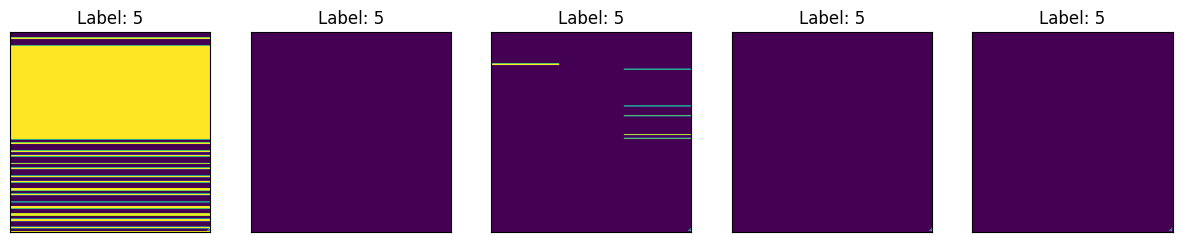

In [ ]:
# Creating a figure and axes for the poisoned images
fig, axes = plt.subplots(
    nrows=1,
    ncols=min(5, len(poisoned_images)),
    squeeze=True,
    figsize=(15, 5)
)

# Plotting the poisoned images
for i in range(min(5, len(poisoned_images))):
    axes[i].imshow(poisoned_images[i])
    axes[i].set_title(f"Label: {np.argmax(poisoned_labels[i])}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Removing any extra subplots
for j in range(len(poisoned_images), len(axes)):
    fig.delaxes(axes[j])

# Showing the plot
plt.show()
